In [3]:
import os
import shutil
import glob
import numpy as np 
import pandas as pd
import pretty_midi
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
import librosa.display
import matplotlib.pyplot as plt
# from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools
root_dir = '/home/kennardpeters/Documents/'
data_dir = root_dir + '/PyDrillData'
# music_dataset_lpd_dir = root_dir + '/Music Dataset/midis/lmd_matched'

In [4]:
# Loading
combined_pianorolls = torch.load(os.path.join(data_dir, 'jazz_rolls_vae.pt')) / 127.0
pianoroll_lengths = torch.load(os.path.join(data_dir, 'jazz_rolls_vae_lengths.pt'))
pianoroll_lengths = pianoroll_lengths.numpy()
pianoroll_cum_lengths = pianoroll_lengths.cumsum()

In [5]:
# Remake the list of pianorolls - ensuring all songs are multiple of 32
pianorolls_list = []
pianorolls_list.append(combined_pianorolls[:, :(pianoroll_cum_lengths[0] - pianoroll_cum_lengths[0] % 32), :])
for i in range(len(pianoroll_cum_lengths) - 1):
  length = pianoroll_cum_lengths[i+1] - pianoroll_cum_lengths[i]
  # Get the nearest multiple of 32
  length_multiple = length - (length % 32)
  pianoroll = combined_pianorolls[:, pianoroll_cum_lengths[i]:(pianoroll_cum_lengths[i] + length_multiple), :]
  pianorolls_list.append(pianoroll)

In [6]:
# Creating dataset and dataloader
from torch.utils.data import Dataset, DataLoader

In [7]:
class CombinedDataset(Dataset):
  def __init__(self, pianorolls, instrument_id):
    self.data = pianorolls
    self.length = int(pianorolls.size(1) / 32)
    self.instrument_id = instrument_id

  def __getitem__(self, index):
    sequence = self.data[self.instrument_id, (index * 32):((index+1) * 32), :]
    return sequence
    
  def __len__(self):
    return self.length

In [8]:
# Melody-conditional dataset NEW - returns BOTH the previous harmony, and current melody, and current harmony
# only outputs samples with all tracks non-empty
class ConditionalDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 1000, seq_length = 50, instrument = 'guitar'):

    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length
    self.instrument = instrument

  def __getitem__(self, index):
    # Choose a random song id
    valid_sequence = False

    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      if song_length > (self.seq_length * 2 + 5):

        # Choose a random start window
        start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
        start_time = start_time - (start_time % 32)

        # train_sequence: 1 (piano) x seq_length x 128
        piano_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

        if self.instrument == 'guitar':
          past_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][1, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'bass':
          past_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][2, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'strings':
          past_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][3, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'drums':
          past_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][4, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        else:
          past_sequence = None
          target_sequence = None

        if piano_sequence.sum() != 0 and past_sequence.sum() != 0 and target_sequence.sum() != 0:
          valid_sequence = True
        else:
          if random.random() < 0.1:
            valid_sequence = True
          
    return piano_sequence, past_sequence, target_sequence
  def __len__(self):
    return self.length

In [9]:
# Melody prediction dataset - predict the next melody given the current melody
class MelodyDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):
    # Choose a random song id
    valid_sequence  = False
    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      if song_length > (self.seq_length * 2 + 5):
        # Choose a random start window
        start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
        start_time = start_time - (start_time % 32)
        # train_sequence: 1 (piano) x seq_length x 128
        train_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
        # target_sequence: 1 (piano) x seq_length x 128
        target_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

        valid_sequence = True
    
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

## VAE Execution

In [10]:
# @title VAE Helper Functions

def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]

    This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
    just -1/2*(zs**2)
    """
    b, n, k = zs.size()
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs**2)
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    k = kplus1-1
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    eps = torch.randn(b, n_samples, k, device=phi.device)
    return eps*sig.view(b,1,1) + mu.view(b,1,k)

In [11]:
class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()

        # Define the recognition model (encoder or q) part
        # Input size: num_channels (1) x seq_length (32) x n_pitches (128)
        self.q_conv_1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (2, 8), stride = (2, 8))
        self.q_fc_phi = nn.Linear(256, K+1)

        # Define the generative model (decoder or p) part
        self.p_fc_upsample = nn.Linear(K, 256)
        self.p_deconv_1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = (2, 8), stride = (2, 8))
        self.p_deconv_2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.p_deconv_3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4), stride = (4, 4))

        # Define a special extra parameter to learn scalar sig_x for all pixels
        self.log_sig_x = nn.Parameter(torch.zeros(()))
    
    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        x = x.unsqueeze(1)
        s = F.relu(self.q_conv_1(x))
        s = F.relu(self.q_conv_2(s))
        s = F.relu(self.q_conv_3(s))
        # Flatten s
        flat_s = s.view(s.size()[0], -1)
        phi = self.q_fc_phi(flat_s)
        return phi

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        # Note that for the purposes of passing through the generator, we need
        # to reshape zs to be size [b*n,k]
        b, n, k = zs.size()
        s = zs.view(b*n, -1)
        # Unflatten
        s = F.relu(self.p_fc_upsample(s)).unsqueeze(2).unsqueeze(3)
        s = F.relu(self.p_deconv_1(s))
        s = F.relu(self.p_deconv_2(s))
        s = self.p_deconv_3(s)
        mu_xs = s.view(b, n, -1)
        return mu_xs
    
    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        """Run input end to end through the VAE and compute the ELBO using n
        samples of z
        """
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

In [12]:
def train_vae(vae, dataloader, epochs=10):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-6)
    elbo_vals = []
    vae.to(device)
    vae.train()
    for epoch in trange(epochs, desc='Epochs'):
        for sequence in tqdm(dataloader, total=len(dataset)//100, desc='Batches', leave=False):
            sequence = sequence.to(device)
            opt.zero_grad()
            loss = -vae.elbo(sequence)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
    vae.to('cpu')
    vae.eval()
    return elbo_vals

8 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2232263684272766


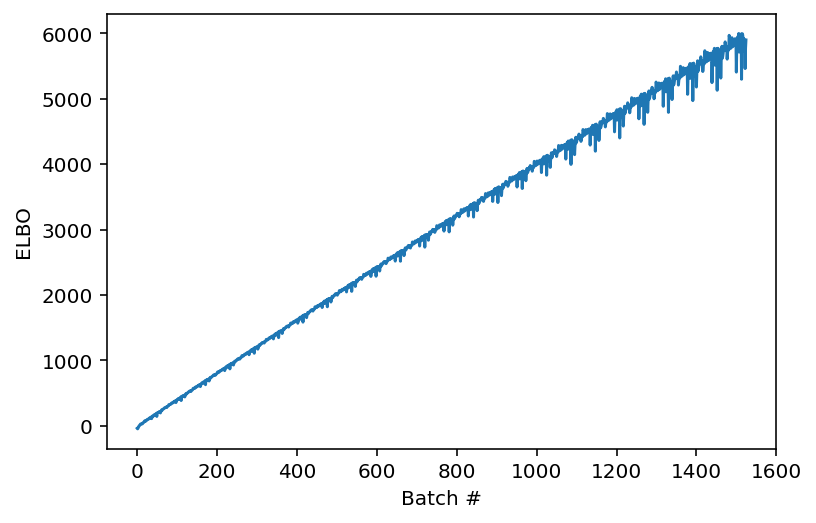

8 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2197183519601822


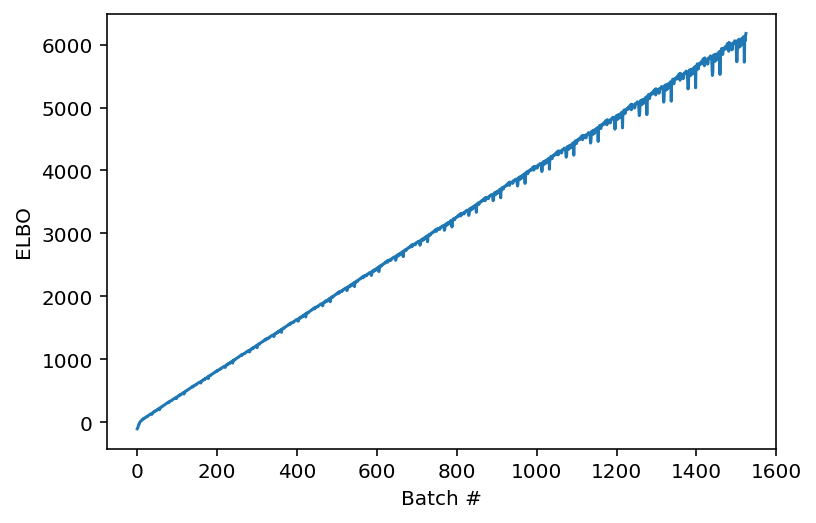

8 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2217492014169693


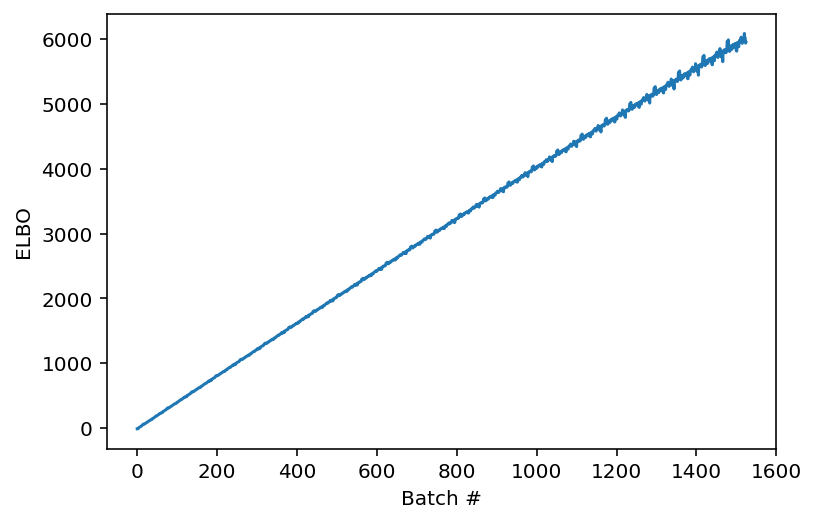

8 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22022400796413422


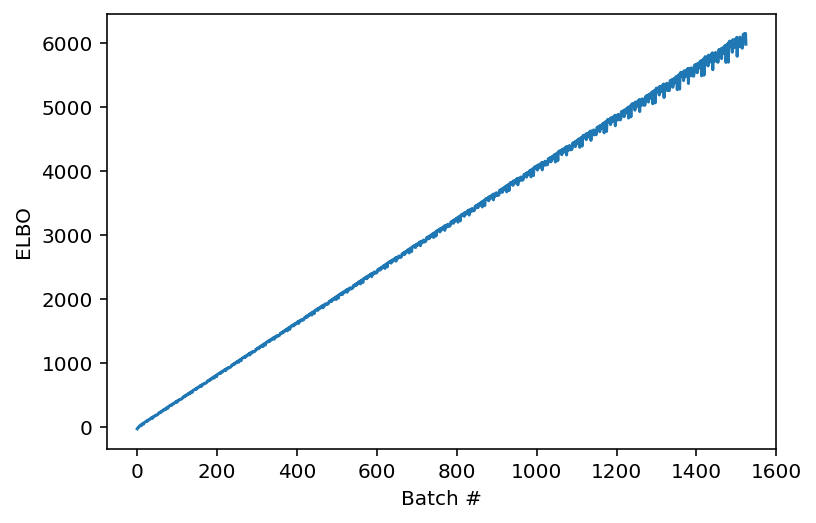

8 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2207919806241989


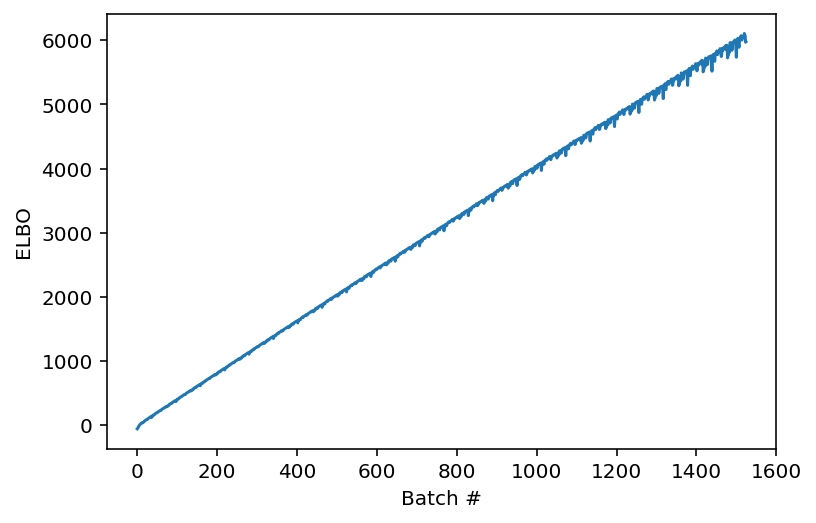

16 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2233155220746994


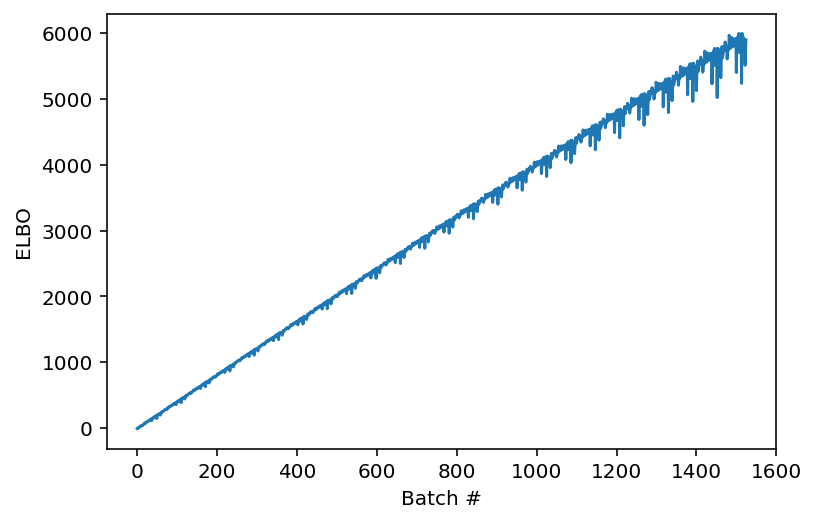

16 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.21972736716270447


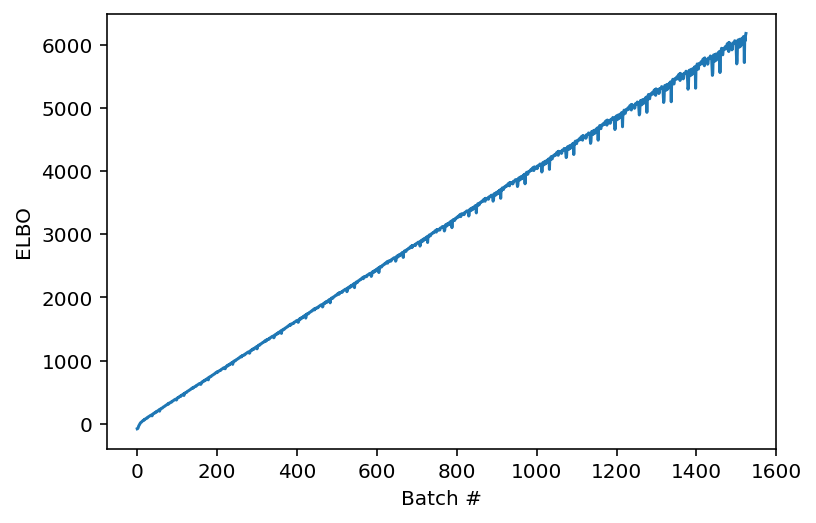

16 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22169660031795502


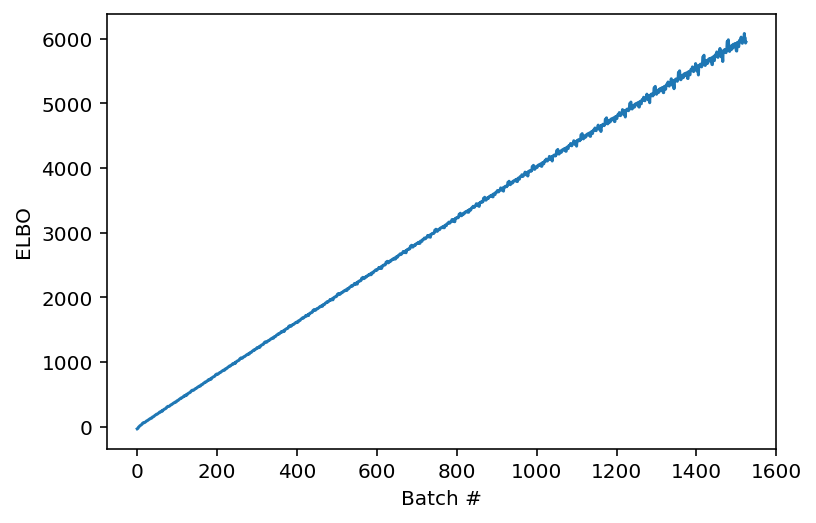

16 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22025205194950104


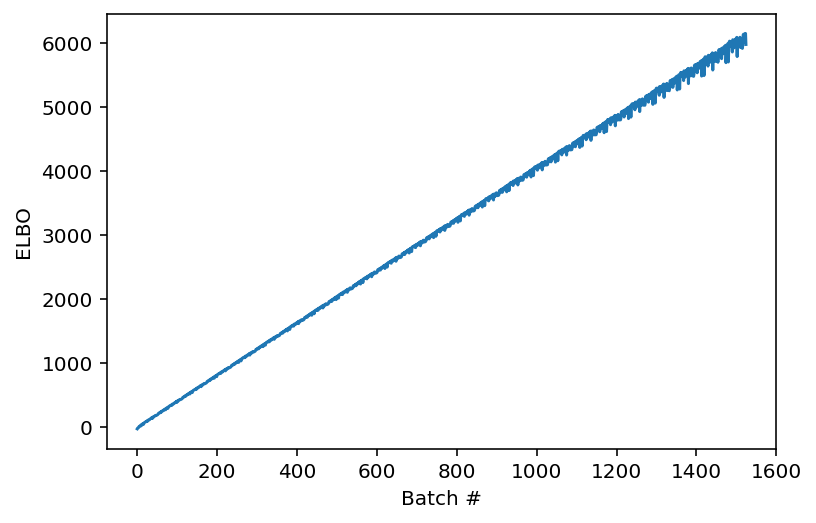

16 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22101160883903503


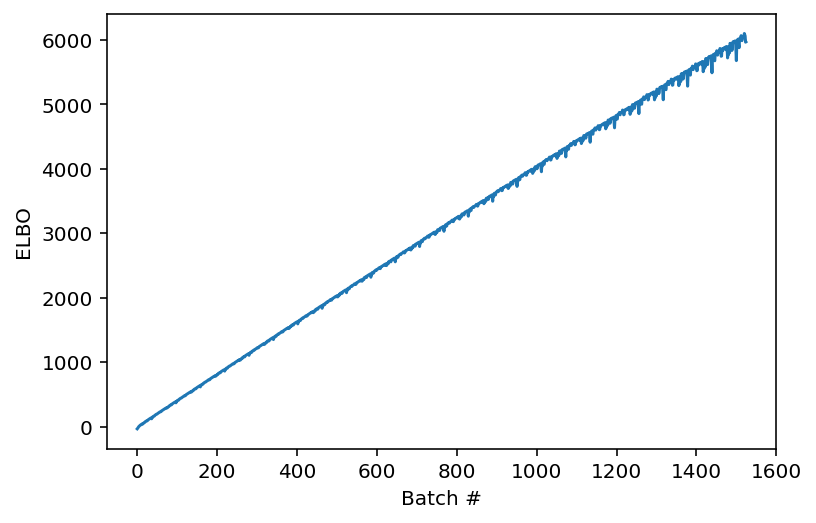

32 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22360588610172272


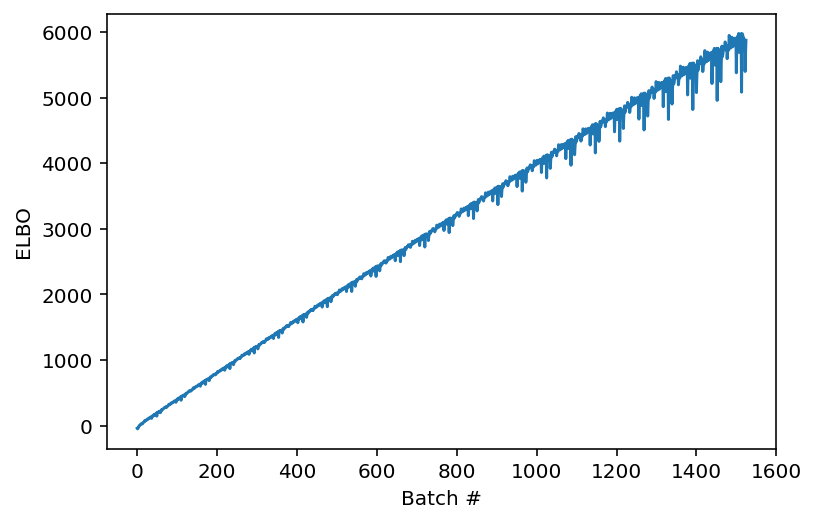

32 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.21996986865997314


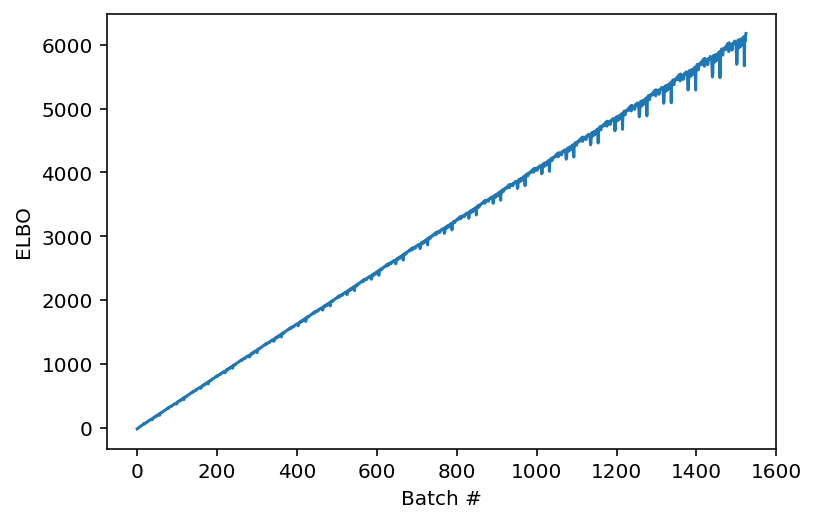

32 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.2217337042093277


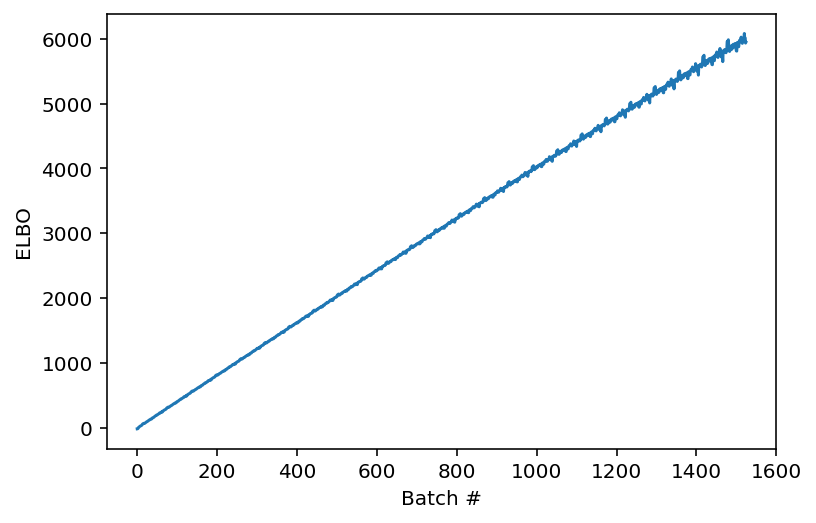

32 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22046971321105957


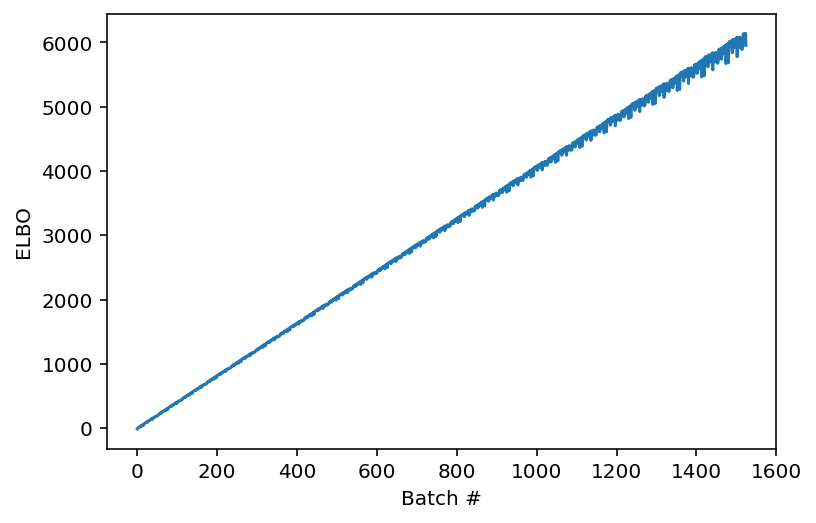

32 <module 'music21.instrument' from '/home/kennardpeters/.local/lib/python3.8/site-packages/music21/instrument.py'>


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Learned sigma_x is 0.22129221260547638


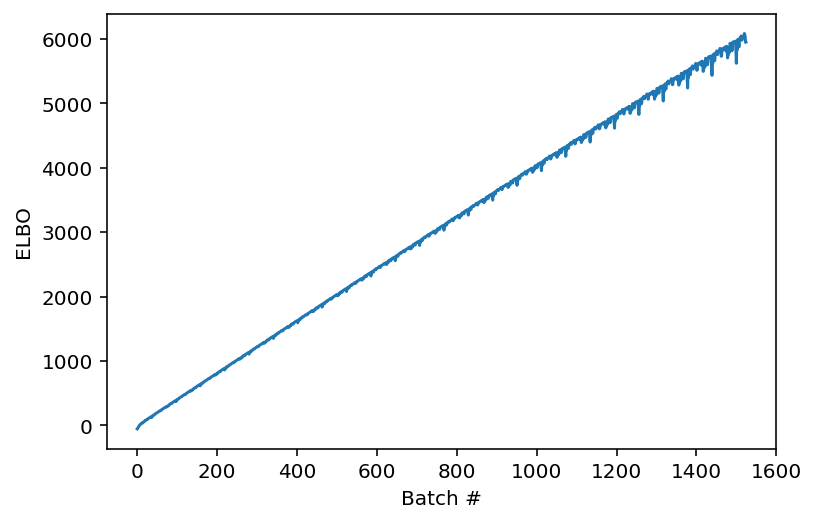

In [15]:
# Code to generate VAEs
for K in [8, 16, 32]:
  instruments = ['piano', 'guitar', 'bass', 'strings', 'drums']
  for i in range(5):
    print(K, instrument)
    dataset = CombinedDataset(combined_pianorolls, instrument_id = i)
    piano_loader = DataLoader(dataset, batch_size = 32, drop_last=True)

    vae = ConvVAE(K = K)
    elbo_vals = train_vae(vae, piano_loader, epochs = 25)
    model_name = 'VAE_{}_{}'.format(instruments[i], K)
    save_path = os.path.join(data_dir, model_name)
    torch.save(vae.state_dict(), save_path)

    print(f'Learned sigma_x is {torch.exp(vae.log_sig_x)}')
    plt.figure()
    plt.plot(elbo_vals)
    plt.xlabel('Batch #')
    plt.ylabel('ELBO')
    plt.show()

## Training Melody and Conditional NNs

In [20]:
# @title Load trained VAEs (Run me)
# Specify dimensionality of VAEs you want (K = 8, 16, 32, 64)
K = 16

model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

model_name = 'VAE_guitar_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
guitar_vae = ConvVAE(K=K).to(device)
guitar_vae.load_state_dict(torch.load(save_path))
guitar_vae.eval()

model_name = 'VAE_bass_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
bass_vae = ConvVAE(K=K).to(device)
bass_vae.load_state_dict(torch.load(save_path))
bass_vae.eval()

model_name = 'VAE_strings_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
strings_vae = ConvVAE(K=K).to(device)
strings_vae.load_state_dict(torch.load(save_path))
strings_vae.eval()

model_name = 'VAE_drums_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
drums_vae = ConvVAE(K=K).to(device)
drums_vae.load_state_dict(torch.load(save_path))
drums_vae.eval()

ConvVAE(
  (q_conv_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
  (q_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(4, 4))
  (q_conv_3): Conv2d(128, 256, kernel_size=(2, 8), stride=(2, 8))
  (q_fc_phi): Linear(in_features=256, out_features=17, bias=True)
  (p_fc_upsample): Linear(in_features=16, out_features=256, bias=True)
  (p_deconv_1): ConvTranspose2d(256, 128, kernel_size=(2, 8), stride=(2, 8))
  (p_deconv_2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4))
  (p_deconv_3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(4, 4))
)

In [49]:
# @title Conditional and Melody NN Architectures

# Conditional NN - uses current melody and previous harmony's LATENT vectors to predict next harmony's LATENT vectors
class ConditionalNN(nn.Module):
    def __init__(self, K):
        super(ConditionalNN, self).__init__()

        # self.fc1 = nn.Linear(2*K, 128)
        # self.fc2 = nn.Linear(128, K)
        self.fc1 = nn.Linear(3*K, 16)
        self.fc2 = nn.Linear(16, K)

    def forward(self, prev_harmony, melody):

      x = torch.cat((prev_harmony, melody), axis = 1)
      x = F.relu(self.fc1(x))
      out = self.fc2(x)
      return out

# Melody NN - uses previous melody's LATENT vectors to predict next melody's LATENT VECTORS
class MelodyNN(nn.Module):
    def __init__(self, K):
        super(MelodyNN, self).__init__()
        self.fc1 = nn.Linear(K, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, K)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      out = self.fc3(x)
      return out

In [23]:
# @title Melody NN Training Functions

def run_epoch_MelodyNN(dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = True):
    running_loss = 0
    n_obs = 0
    print(dataloader)
    for train_seq, target_seq in dataloader:
      train_seq = train_seq.to(device)
      target_seq = target_seq.to(device)

      with torch.no_grad():
        train_latent = piano_vae.infer(train_seq.to(device))[:, :-1]
        target_latent = piano_vae.infer(target_seq.to(device))[:, :-1]

      output_latent = melody_nn(train_latent.detach())
      loss = criterion(output_latent, target_latent)

      if is_train == True:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      running_loss += loss.item()
      n_obs += train_seq.size()[0]
    
    return running_loss / n_obs * 100

def training_loop_MelodyNN(piano_vae, melody_nn, optimizer, scheduler, criterion, train_dataloader, test_dataloader, n_epochs = 50):
  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    melody_nn.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = run_epoch_MelodyNN(train_dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = True)
    train_losses.append(train_epoch_loss)
    scheduler.step()
    melody_nn.eval()
    test_epoch_loss = run_epoch_MelodyNN(test_dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = False)
    test_losses.append(test_epoch_loss)
    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))
  return train_losses, test_losses

In [28]:
print(len(pianorolls_list))

66


<class '__main__.MelodyDataset'>
[0.001]
Epoch 1, Train Loss: 0.17851158347802992, Test Loss: 0.21771566820098087, Time: 2022-06-21 18:55:31.973909
[0.00095]
Epoch 2, Train Loss: 0.1439314918836317, Test Loss: 0.15252056180324872, Time: 2022-06-21 18:55:55.422516
[0.0009025]
Epoch 3, Train Loss: 0.12468122016871348, Test Loss: 0.12274510851420929, Time: 2022-06-21 18:56:19.509564
[0.000857375]
Epoch 4, Train Loss: 0.11657027091532654, Test Loss: 0.10146233780978947, Time: 2022-06-21 18:56:44.235961
[0.0008145062499999999]
Epoch 5, Train Loss: 0.11016344307099644, Test Loss: 0.10079394008498639, Time: 2022-06-21 18:57:08.506267
[0.0007737809374999998]
Epoch 6, Train Loss: 0.10468147627998405, Test Loss: 0.09168336744914996, Time: 2022-06-21 18:57:32.221587
[0.0007350918906249999]
Epoch 7, Train Loss: 0.1007089900182109, Test Loss: 0.09192687342438148, Time: 2022-06-21 18:57:56.887581
[0.0006983372960937497]
Epoch 8, Train Loss: 0.09716202720883302, Test Loss: 0.08374245633021928, Time: 

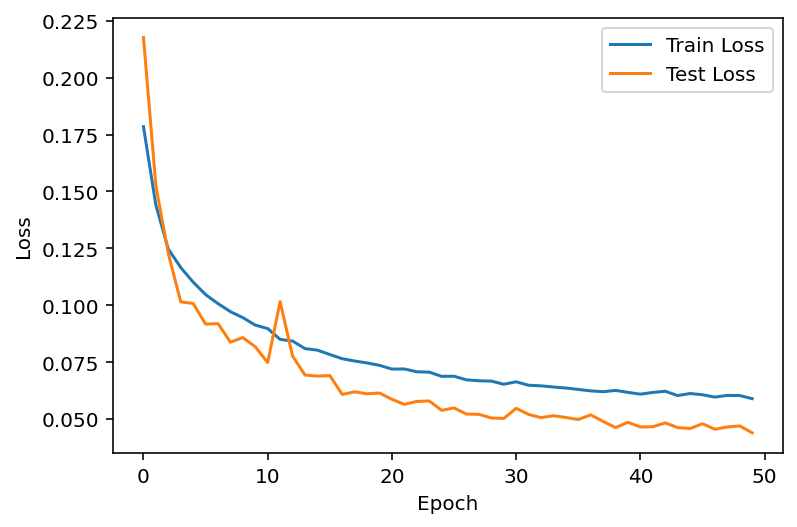

In [29]:
# @title Melody NN Training Loop

n_epochs = 50
lr = 0.001
lr_lambda = 0.95
K = 16

melody_train_dataset = MelodyDataset(pianorolls_list, dataset_length = 32 * 8000, seq_length = 32)
print(type(melody_train_dataset))
melody_train_loader = DataLoader(melody_train_dataset, batch_size = 32, drop_last=True)
melody_test_dataset = MelodyDataset(pianorolls_list[50:], dataset_length = 32 * 1000, seq_length = 32)
melody_test_loader = DataLoader(melody_test_dataset, batch_size = 32, drop_last=True)

# Load the model
model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

melody_nn = MelodyNN(K = K).to(device)
optimizer = torch.optim.Adam(melody_nn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.MSELoss()
train_losses, test_losses = training_loop_MelodyNN(piano_vae, melody_nn, optimizer, scheduler, criterion, melody_train_loader, melody_test_loader, n_epochs = n_epochs)

model_name = 'VAE_NN_piano_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
torch.save(melody_nn.state_dict(), save_path)

plt.figure()
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# @title Conditional NN Training Functions

def run_epoch_VAENN(dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = True):
    running_loss = 0
    n_obs = 0

    for piano_seq, past_seq, target_seq in dataloader:
      piano_seq = piano_seq.to(device)
      past_seq = past_seq.to(device)
      target_seq = target_seq.to(device)

      with torch.no_grad():
        piano_latent = piano_vae.infer(piano_seq.to(device))[:, :-1]
        past_latent = harmony_vae.infer(past_seq.to(device))[:, :-1]
        target_latent = harmony_vae.infer(target_seq.to(device))[:, :-1]

      output_latent = conditional_nn(past_latent.detach(), piano_latent.detach())
      loss = criterion(output_latent, target_latent)

      if is_train == True:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      running_loss += loss.item()
      n_obs += piano_seq.size()[0]
    
    return running_loss / n_obs * 100

def training_loop_VAENN(piano_vae, harmony_vae, conditional_nn, optimizer, scheduler, criterion, train_dataloader, test_dataloader, n_epochs = 50):
  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    conditional_nn.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = run_epoch_VAENN(train_dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = True)
    train_losses.append(train_epoch_loss)
    scheduler.step()
    conditional_nn.eval()
    test_epoch_loss = run_epoch_VAENN(test_dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = False)
    test_losses.append(test_epoch_loss)
    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))
  return train_losses, test_losses

In [43]:
type(pianorolls_list[0:50])

list

guitar
[0.001]
Epoch 1, Train Loss: 0.014676085497944769, Test Loss: 0.05987345730886773, Time: 2022-06-28 16:43:06.704378
[0.00095]
Epoch 2, Train Loss: 0.01022062551154761, Test Loss: 0.05242741721538096, Time: 2022-06-28 16:43:40.227231
[0.0009025]
Epoch 3, Train Loss: 0.009757535329137567, Test Loss: 0.055507798514486235, Time: 2022-06-28 16:44:13.635577
[0.000857375]
Epoch 4, Train Loss: 0.009222172515718795, Test Loss: 0.06233885902083785, Time: 2022-06-28 16:44:47.162786
[0.0008145062499999999]
Epoch 5, Train Loss: 0.009236400303886684, Test Loss: 0.05717419548686849, Time: 2022-06-28 16:45:20.795959
[0.0007737809374999998]
Epoch 6, Train Loss: 0.009096200048023207, Test Loss: 0.05276855326153509, Time: 2022-06-28 16:45:54.617616
[0.0007350918906249999]
Epoch 7, Train Loss: 0.00893342689735448, Test Loss: 0.0560639448325901, Time: 2022-06-28 16:46:31.135114
[0.0006983372960937497]
Epoch 8, Train Loss: 0.008598926139168838, Test Loss: 0.051046319343709, Time: 2022-06-28 16:47:04.

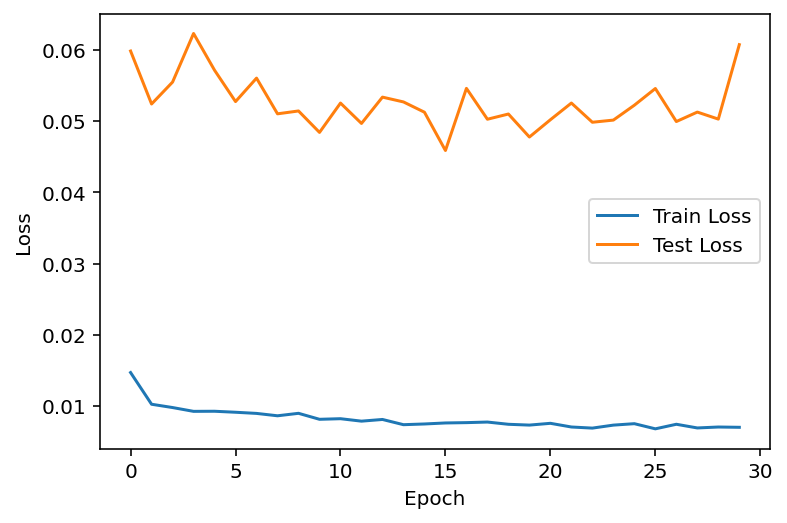

bass
[0.001]
Epoch 1, Train Loss: 0.0003541866797581506, Test Loss: 7.034963947809559e-05, Time: 2022-06-28 17:00:05.153208
[0.00095]
Epoch 2, Train Loss: 1.9488014359470007e-06, Test Loss: 2.5379580128603862e-06, Time: 2022-06-28 17:00:40.280560
[0.0009025]
Epoch 3, Train Loss: 7.33753394605019e-07, Test Loss: 8.35590205561232e-07, Time: 2022-06-28 17:01:14.800733
[0.000857375]
Epoch 4, Train Loss: 4.110001920229478e-07, Test Loss: 8.191243424826577e-07, Time: 2022-06-28 17:01:51.779232
[0.0008145062499999999]
Epoch 5, Train Loss: 2.7889361211546473e-07, Test Loss: 5.884553720164609e-07, Time: 2022-06-28 17:02:28.112507
[0.0007737809374999998]
Epoch 6, Train Loss: 2.084306719442666e-07, Test Loss: 3.8837819017478735e-07, Time: 2022-06-28 17:03:02.771519
[0.0007350918906249999]
Epoch 7, Train Loss: 1.454032166544293e-07, Test Loss: 1.1466526536607624e-06, Time: 2022-06-28 17:03:37.202559
[0.0006983372960937497]
Epoch 8, Train Loss: 1.291836506400225e-07, Test Loss: 2.474266328857111e-0

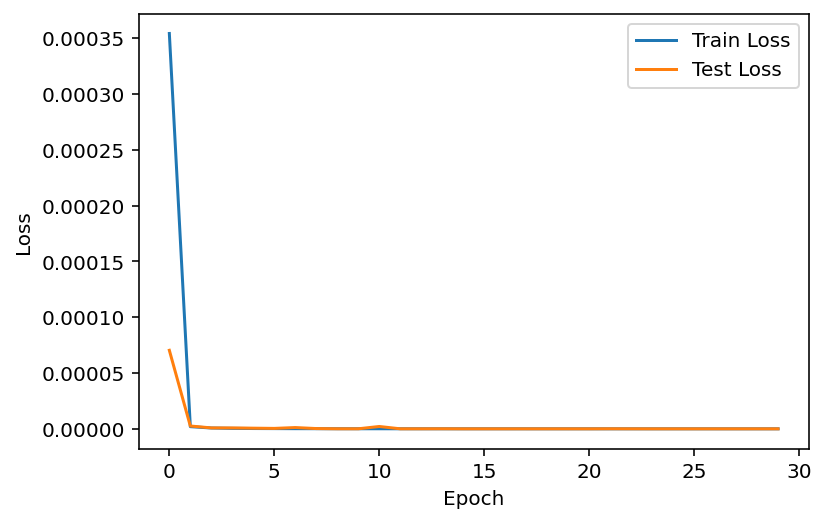

strings
[0.001]
Epoch 1, Train Loss: 0.6017273681616644, Test Loss: 2.985278670908883, Time: 2022-06-28 17:17:21.225543
[0.00095]
Epoch 2, Train Loss: 0.5326527582728886, Test Loss: 3.059114486677572, Time: 2022-06-28 17:17:58.095994
[0.0009025]
Epoch 3, Train Loss: 0.4958546894071333, Test Loss: 5.124811654575751, Time: 2022-06-28 17:18:35.756623
[0.000857375]
Epoch 4, Train Loss: 0.4764943855923775, Test Loss: 4.339551149401814, Time: 2022-06-28 17:19:14.116553
[0.0008145062499999999]
Epoch 5, Train Loss: 0.4609218654644792, Test Loss: 4.791914784838445, Time: 2022-06-28 17:19:52.174853
[0.0007737809374999998]
Epoch 6, Train Loss: 0.44451449308980956, Test Loss: 5.304709774744697, Time: 2022-06-28 17:20:31.600148
[0.0007350918906249999]
Epoch 7, Train Loss: 0.4374010699983046, Test Loss: 3.2836319471476596, Time: 2022-06-28 17:21:10.749165
[0.0006983372960937497]
Epoch 8, Train Loss: 0.4279139297148504, Test Loss: 3.0486773304874077, Time: 2022-06-28 17:21:47.482666
[0.00066342043128

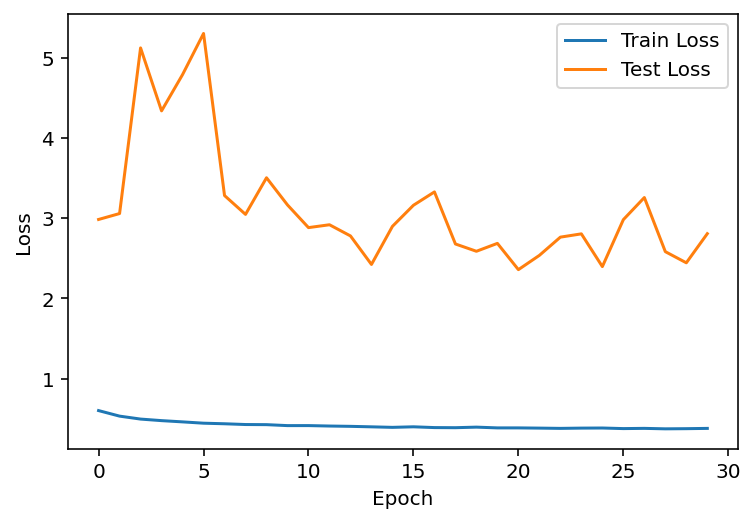

drums
[0.001]
Epoch 1, Train Loss: 0.5594162512905313, Test Loss: 0.44865392573410645, Time: 2022-06-28 17:35:51.695862
[0.00095]
Epoch 2, Train Loss: 0.4572093325215974, Test Loss: 0.37630833212751896, Time: 2022-06-28 17:36:25.744659
[0.0009025]
Epoch 3, Train Loss: 0.41505868734602697, Test Loss: 0.3594326546008233, Time: 2022-06-28 17:37:00.869731
[0.000857375]
Epoch 4, Train Loss: 0.39627881994056224, Test Loss: 0.6103180850623176, Time: 2022-06-28 17:37:36.145829
[0.0008145062499999999]
Epoch 5, Train Loss: 0.36564155546184335, Test Loss: 0.3277439086697996, Time: 2022-06-28 17:38:10.208818
[0.0007737809374999998]
Epoch 6, Train Loss: 0.35751841852397775, Test Loss: 0.37380696589243595, Time: 2022-06-28 17:38:44.544926
[0.0007350918906249999]
Epoch 7, Train Loss: 0.34752343944892344, Test Loss: 0.39004615269077475, Time: 2022-06-28 17:39:19.014079
[0.0006983372960937497]
Epoch 8, Train Loss: 0.33400656916383015, Test Loss: 0.37416234115371483, Time: 2022-06-28 17:39:52.579944
[0.

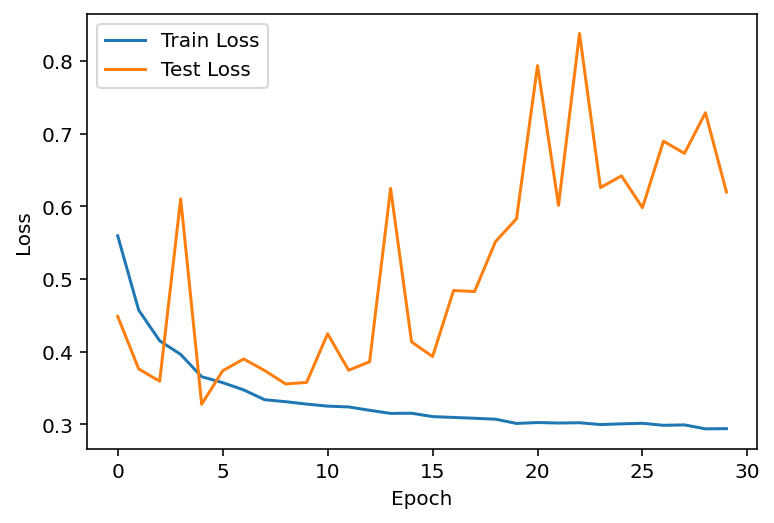

In [50]:
# @title Conditional NN Training Loop

n_epochs = 30
lr = 0.001
lr_lambda = 0.95
K = 8

for instrument in ['guitar', 'bass', 'strings', 'drums']:
  print(instrument)

  cond_train_dataset = ConditionalDataset(pianorolls_list[0:50], dataset_length = 32 * 4000, seq_length = 32, instrument = instrument)
  cond_train_loader = DataLoader(cond_train_dataset, batch_size = 16, drop_last=True)
  cond_test_dataset = ConditionalDataset(pianorolls_list[50:], dataset_length = 32 * 1000, seq_length = 32, instrument = instrument)
  cond_test_loader = DataLoader(cond_test_dataset, batch_size = 16, drop_last=True)

  # Load the model
  model_name = 'VAE_{}_{}'.format(instrument, K)
  save_path = os.path.join(data_dir, model_name)
  harmony_vae = ConvVAE(K=K).to(device)
  harmony_vae.load_state_dict(torch.load(save_path))
  harmony_vae.eval()

  conditional_nn = ConditionalNN(K = K).to(device)
  optimizer = torch.optim.Adam(conditional_nn.parameters(), lr = lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
  criterion = nn.MSELoss()
  train_losses, test_losses = training_loop_VAENN(piano_vae, harmony_vae, conditional_nn, optimizer, scheduler, criterion, cond_train_loader, cond_test_loader, n_epochs = n_epochs)

  model_name = 'VAE_NN_{}_{}'.format(instrument, K)
  save_path = os.path.join(data_dir, model_name)
  torch.save(conditional_nn.state_dict(), save_path)

  plt.figure()
  plt.plot(train_losses, label = 'Train Loss')
  plt.plot(test_losses, label = 'Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

[0.001]
Epoch 1, Train Loss: 0.17780375314650881, Test Loss: 0.13271000976092182, Time: 2022-06-28 17:53:50.652661
[0.00095]
Epoch 2, Train Loss: 0.14471153994163613, Test Loss: 0.12158381146437022, Time: 2022-06-28 17:54:15.992638
[0.0009025]
Epoch 3, Train Loss: 0.1280055185303354, Test Loss: 0.11165925200039056, Time: 2022-06-28 17:54:41.598898
[0.000857375]
Epoch 4, Train Loss: 0.11846444505317778, Test Loss: 0.10559336978476494, Time: 2022-06-28 17:55:07.376115
[0.0008145062499999999]
Epoch 5, Train Loss: 0.11181236279262521, Test Loss: 0.09925871330488008, Time: 2022-06-28 17:55:33.515719
[0.0007737809374999998]
Epoch 6, Train Loss: 0.10648347566093436, Test Loss: 0.0933786251815036, Time: 2022-06-28 17:56:02.440708
[0.0007350918906249999]
Epoch 7, Train Loss: 0.10281345287985459, Test Loss: 0.0953523536445573, Time: 2022-06-28 17:56:31.834966
[0.0006983372960937497]
Epoch 8, Train Loss: 0.0985133165575462, Test Loss: 0.08843776279391023, Time: 2022-06-28 17:56:58.606450
[0.00066

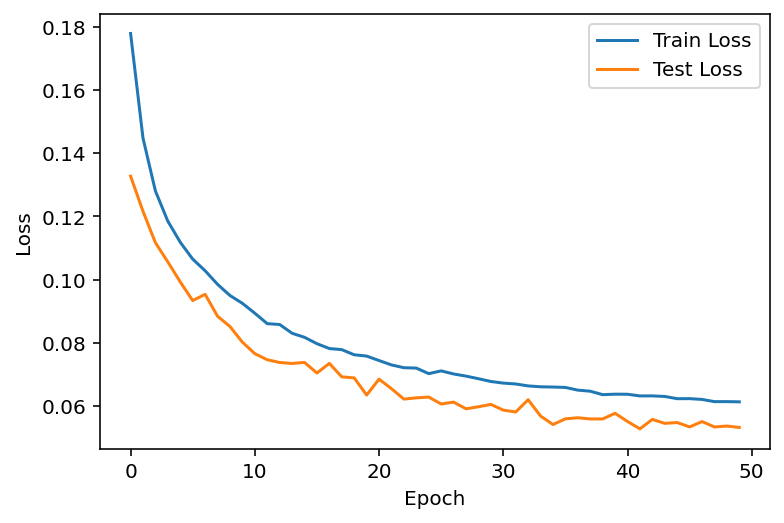

guitar
[0.001]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 48x16)

In [51]:
# @title Conditional NN Training Loop #2

n_epochs = 50
lr = 0.001
lr_lambda = 0.95
K = 16

melody_train_dataset = MelodyDataset(pianorolls_list, dataset_length = 32 * 8000, seq_length = 32)
melody_train_loader = DataLoader(melody_train_dataset, batch_size = 32, drop_last=True)
melody_test_dataset = MelodyDataset(pianorolls_list[0:50], dataset_length = 32 * 1000, seq_length = 32)
melody_test_loader = DataLoader(melody_test_dataset, batch_size = 32, drop_last=True)

# Load the model
model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

melody_nn = MelodyNN(K = K).to(device)
optimizer = torch.optim.Adam(melody_nn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.MSELoss()
train_losses, test_losses = training_loop_MelodyNN(piano_vae, melody_nn, optimizer, scheduler, criterion, melody_train_loader, melody_test_loader, n_epochs = n_epochs)

model_name = 'VAE_NN_piano_{}'.format(K)
save_path = os.path.join(data_dir, model_name)
torch.save(melody_nn.state_dict(), save_path)

plt.figure()
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

n_epochs = 50
lr = 0.001
lr_lambda = 0.95
K = 16

for instrument in ['guitar', 'bass', 'strings', 'drums']:
  print(instrument)

  cond_train_dataset = ConditionalDataset(pianorolls_list, dataset_length = 32 * 8000, seq_length = 32, instrument = instrument)
  cond_train_loader = DataLoader(cond_train_dataset, batch_size = 32, drop_last=True)
  cond_test_dataset = ConditionalDataset(pianorolls_list[0:500], dataset_length = 32 * 1000, seq_length = 32, instrument = instrument)
  cond_test_loader = DataLoader(cond_test_dataset, batch_size = 32, drop_last=True)

  # Load the model
  model_name = 'VAE_{}_{}'.format(instrument, K)
  save_path = os.path.join(data_dir, model_name)
  harmony_vae = ConvVAE(K=K).to(device)
  harmony_vae.load_state_dict(torch.load(save_path))
  harmony_vae.eval()

  conditional_nn = ConditionalNN(K = K).to(device)
  optimizer = torch.optim.Adam(conditional_nn.parameters(), lr = lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
  criterion = nn.MSELoss()
  train_losses, test_losses = training_loop_VAENN(piano_vae, harmony_vae, conditional_nn, optimizer, scheduler, criterion, cond_train_loader, cond_test_loader, n_epochs = n_epochs)

  model_name = 'VAE_NN_{}_{}'.format(instrument, K)
  save_path = os.path.join(data_dir, model_name)
  torch.save(conditional_nn.state_dict(), save_path)

  plt.figure()
  plt.plot(train_losses, label = 'Train Loss')
  plt.plot(test_losses, label = 'Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Using Trained VAEs and NNs to Generate Music